# Lab 6: Comparing Three or More Groups with ANOVA
## Created by Jane and Kristin, modified by Xinyue

Often, we have to compare data from three or more groups to see if one or more of them is different from the others. To do this, scientists use a statistic called the _F_- statistic, defined as $F=\frac{Var_{between}}{Var_{within}}$. The variability between groups is the sum of the squared differences between the group means and the grand mean. The variability within groups is the sum of the group variances. In LS 40, we will use a variation of the F-statistic that does not require squaring, which is called the _F_-like statistic.

1. Import pandas, Numpy, Seaborn and Pyplot.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In this lab, we will examine the results of a pharmaceutical company's study comparing the effectiveness of different pain relief medications on migraine headaches. For the experiment, 27 volunteers were selected and 9 were randomly assigned to one of three
drug formulations. The subjects were instructed to take the drug during their next migraine headache episode and to report their pain on a scale of 1 = no pain to 10 = extreme pain 30 minutes after taking the drug.

2. Using the pandas `read_csv` function, import the file `migraines.csv` and show the data.

In [8]:
migraines = pd.read_csv("migraines.csv")
migraines

Drug A  Drug B  Drug C
0       4       7       6
1       5       8       7
2       4       4       6
3       2       5       6
4       2       4       7
5       4       6       5
6       3       5       6
7       3       8       5
8       3       7       5

3. Visualize the data. Use as many different plots as you need to get a sense of the distributions. What are your initial impressions?

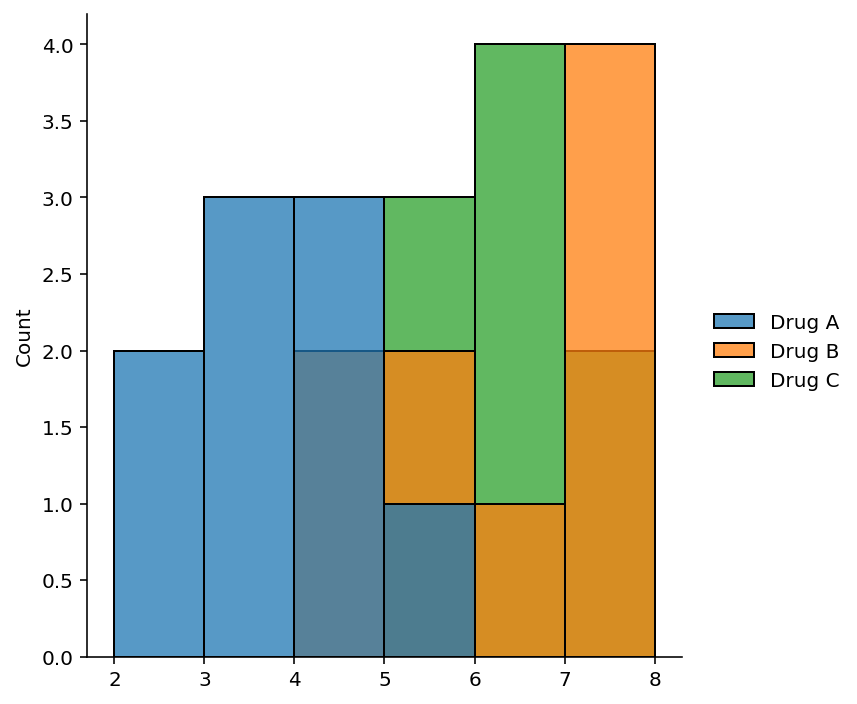

In [11]:
sns.displot(migraines)

## Computing the _F_-like statistic

In the next several exercises, you will compute the _F_-like statistic for your data. 

<h2>
<p align="center">
    <i>F</i>-like=\[\frac{n_{a}|\widetilde{a}-\widetilde{G}|+n_{b}|\widetilde{b}-\widetilde{G}|+n_{c}|\widetilde{c}-\widetilde{G}|}{\Sigma|a_{i}-\widetilde{a}|+\Sigma|b_{i}-\widetilde{b}|+\Sigma|c_{i}-\widetilde{c}|}\]
</p>
</h2>
    
Each quantity you compute in this section should be assigned to a variable.

4. Find the median of each column. HINT: pandas data frames have a built-in function for columnwise medians, so you can just use `df.median()`, where `df` is the name of your data frame.

In [92]:
meds = migraines.median()
meds

Drug A    3.0
Drug B    6.0
Drug C    6.0
dtype: float64

5. Find the grand median (the median of the whole sample). HINT: Use `np.median`.

In [19]:
grand = np.median(migraines)

6. Find the numerator of the _F_-like statistic (variation among groups).  HINT: When working with data frames and NumPy arrays, you can do computations like addition and multiplication directly, without for loops (unlike in regular Python). Also, Numpy has `abs` and `sum` functions.

In [27]:
num = np.sum(len(migraines) * abs(meds - grand)) 
num

36.0

7. Compute the denominator of the _F_-like statistic. This represents variation within groups. HINT: Numpy and pandas will handle columns automatically.

In [29]:
den = np.sum(np.sum(np.abs(migraines - meds)))
den

24.0

8. Compute _F_-like, which is the ratio $\frac{\text{variation among groups}}{\text{variation within groups}}$.

In [30]:
num/den

1.5

## Bootstrapping

We now want to find a p-value for our data by simulating the null hypothesis. This, of course, means computing the _F_-like statistic each time, which takes a lot of code and would make a mess in the bootstrap loop. Instead, we will package our code into a function and call this function whereever necessary.

9. Write a function that will compute the _F_-like statistic for this dataset or one of the same size.

In [77]:
def Flike(df):
    meds = df.median()
    grand = np.median(df)
    num = np.sum(len(df) * abs(meds - grand))
    den = np.sum(np.sum(np.abs(df - meds)))
    result = num/den
    return(result)

We now want to simulate the null hypothesis that there is no difference between the groups. To do this, we have to make all the data into one dataset, sample pseudo-groups from it, and compute the _F_-like statistic for the resampled data.

10. Use the code `alldata = np.concatenate([migraine["Drug A"], migraine["Drug B"], migraine["Drug C"]])` (this assumes your data frame is called "migraine") to put all the data into one 1-D array. 

In [33]:
alldata = np.concatenate([migraines["Drug A"], migraines["Drug B"], migraines["Drug C"]])

11. Sample three groups of the appropriate size from `alldata`. Assign each to a variable.

In [37]:
A = np.random.choice(alldata, len("Drug A"))
B = np.random.choice(alldata, len("Drug B"))
C = np.random.choice(alldata, len("Drug C"))

12. Make the three samples into a data frame. To do this, use the NumPy function `column_stack` to put the 1-D arrays side by side and then use the pandas function `DataFrame` to convert the result into a data frame.

In [69]:
resamps = np.column_stack([A, B, C])
pd.DataFrame(resamps)

0  1  2
0  3  5  5
1  8  5  6
2  5  3  4
3  7  5  2
4  3  4  6
5  4  3  5

13. Compute the _F_-like statistic for your resampled data.

14. Do the above steps 10,000 times to simulate the null hypothesis, storing the results.

In [81]:
sims = np.zeros(10000)

for i in range(10000):
    A = np.random.choice(alldata, len(migraines))
    B = np.random.choice(alldata, len(migraines))
    C = np.random.choice(alldata, len(migraines))
    resampling = np.column_stack([A, B, C])
    result = Flike(pd.DataFrame(resampling))
    sims[i] = result



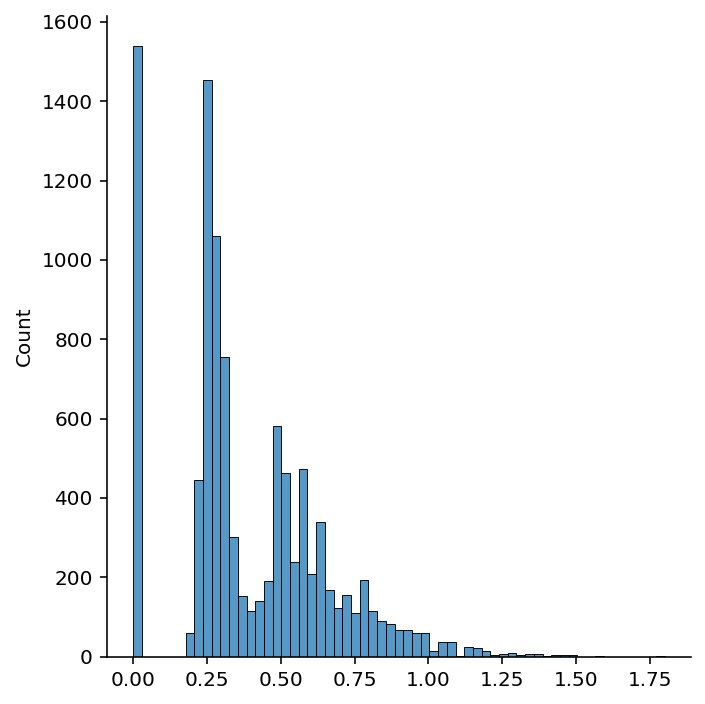

In [82]:
sns.displot(sims)

15. Find the p-value for your data. What do you conclude about the migraine treatments? Use $\alpha$=0.05 for NHST.

In [85]:
np.sum(sims >= 1.5)
pval = 6/10000
pval

0.0006

## Post Hoc Analysis

Having obtained a significant result from the omnibus test, we can now try to track down the source of the significance. Which groups are actually different from which?

16. Perform pairwise two-group comparisons and record the p-value for each.

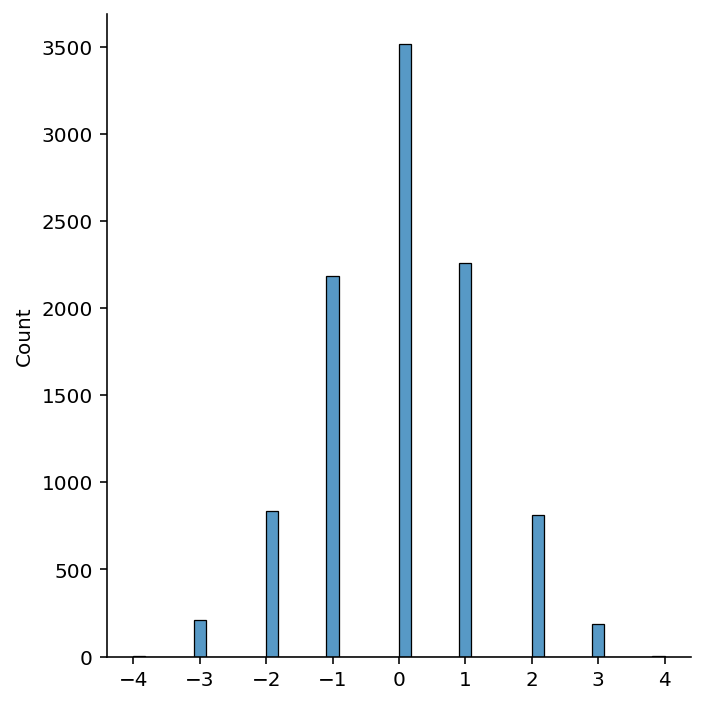

In [90]:
pop = np.concatenate([A,B])

store = np.zeros(10000)
for i in range(10000):
    Asim = np.random.choice(pop, len(migraines))
    Bsim = np.random.choice(pop, len(migraines))
    Amed = np.median(Asim)
    Bmed = np.median(Bsim)
    difMed = Amed - Bmed
    store[i] = difMed

sns.displot(store)

In [100]:
meds = migraines.median()
meds
diffMed = -3

(np.sum(store >= 3) + np.sum(store <= -3)) / 10000

0.0407

17. Use the list of p-values from your two-group comparisons and the Benjamini-Hochberg method below to determine which two-group comparisons have a significant difference at $\alpha$=0.05. See more details in "Controlling the False Positive Rate with Multiple Comparisons Corrections" PDF on Week 6 on CCLE site. \
\
`import statsmodels.stats.multitest as smm` \
`smm.multipletests(pvals, alpha=my_alpha, method='fdr_bh')`

SyntaxError: invalid syntax (<ipython-input-95-d55528c377ca>, line 1)

18. Write a sentence or two describing your findings.